# Return Period for La ReUnion Best Track Data

This notebook reviews the return period using La ReUnion Best Track data

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [ ]:
import geopandas as gpd
import pandas as pd
import math
from pathlib import Path
import os
from datetime import datetime
from shapely.geometry import Point
from src.datasources import codab, rsmc, helpers
from src.constants import *

In [4]:
save_dir = rsmc.DATA_DIR / "public" / "exploration" / "moz" / "ecmwf_hindcast"

<Axes: >

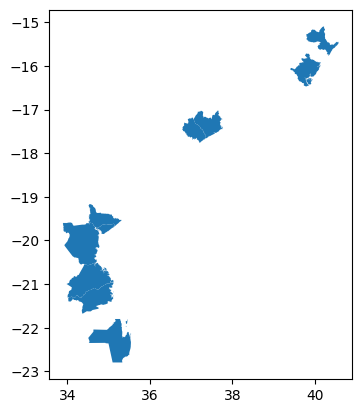

In [7]:
adm2_path = (
    Path(AA_DATA_DIR)
    / "public"
    / "raw"
    / "moz"
    / "cod_ab"
    / "moz_admbnda_adm2_ine_20190607.shp"
)
gdf_adm2 = gpd.read_file(adm2_path)
gdf_adm2_sel = gdf_adm2[gdf_adm2.ADM2_PT.isin(ADMS2)]
gdf_adm2_sel.plot()

<Axes: >

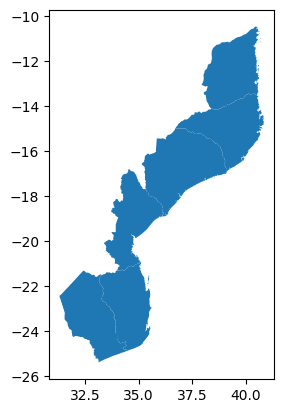

In [8]:
adm = codab.load_codab(aoi_only=True)
adm.plot()

In [9]:
adm2_setting = False
if adm2_setting:
    adm = gdf_adm2_sel.copy()

In [10]:
# loading all actual cyclone tracks
cyclone_tracks = pd.read_csv(
    rsmc.DATA_DIR
    / "private"
    / "raw"
    / "moz"
    / "rsmc"
    / "data_cyclone_SWIO_19851986_to_20222023.csv"
)

In [12]:
cyclone_tracks["Lat"] = cyclone_tracks["Lat"].apply(
    lambda x: -x if x > 0 else x
)
cyclone_tracks_buffer = cyclone_tracks.copy()
cyclone_tracks_buffer["RMW_km"] = cyclone_tracks_buffer["RMW (mn)"] * KPH2KNOTS

In [13]:
cyclone_tracks_buffer["RMW_km"] = (
    cyclone_tracks_buffer["RMW_km"].fillna(0.001).replace(0, 0.001)
)

In [17]:
cyclone_tracks["geometry"] = cyclone_tracks.apply(
    lambda row: Point(row["Lon"], row["Lat"]), axis=1
)
cyclone_tracks_gdf = gpd.GeoDataFrame(
    cyclone_tracks, geometry="geometry", crs=EPSG_CRS
)
cyclone_tracks_buffer["geometry"] = cyclone_tracks.apply(
    lambda row: Point(row["Lon"], row["Lat"]), axis=1
)
cyclone_tracks_gdf_buffer = gpd.GeoDataFrame(
    cyclone_tracks_buffer, geometry="geometry", crs=EPSG_CRS
)
cyclone_tracks_gdf_buffer = cyclone_tracks_gdf_buffer.to_crs(epsg=MOZ_CRS)
cyclone_tracks_gdf_buffer["geometry"] = (
    cyclone_tracks_gdf_buffer.geometry.buffer(
        cyclone_tracks_gdf_buffer["RMW_km"]
        * 1000  # Convert RMW from km to meters
    )
)
cyclone_tracks_gdf_buffer = cyclone_tracks_gdf_buffer.to_crs(epsg=GEO_CRS)

In [18]:
cyclone_tracks_sel = gpd.sjoin(
    cyclone_tracks_gdf, adm, how="inner", predicate="intersects"
)
cyclone_tracks_sel_adm2 = gpd.sjoin(
    cyclone_tracks_gdf, gdf_adm2_sel, how="inner", predicate="intersects"
)
cyclone_tracks_sel_buffer = gpd.sjoin(
    cyclone_tracks_gdf_buffer, adm, how="inner", predicate="intersects"
)
cyclone_tracks_sel_adm2_buffer = gpd.sjoin(
    cyclone_tracks_gdf_buffer,
    gdf_adm2_sel,
    how="inner",
    predicate="intersects",
)

<Axes: >

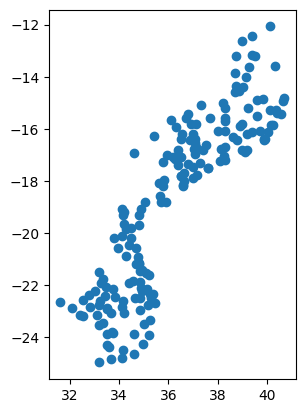

In [19]:
cyclone_tracks_sel.plot()

<Axes: >

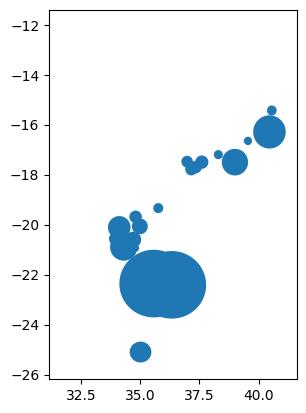

In [20]:
cyclone_tracks_sel_buffer.plot()

<Axes: >

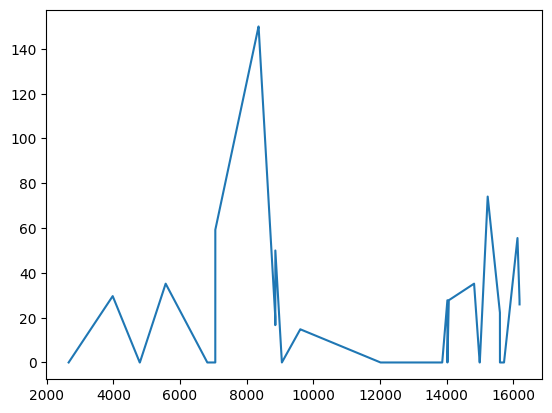

In [21]:
cyclone_tracks_sel_adm2_buffer["RMW_km"].plot()

In [22]:
cyclone_tracks_sel["Name"].unique()

array(['FILAO', 'DESSILIA', 'NADIA', 'BONITA', 'LISETTE', 'A19798',
       'ASTRIDE', 'ELINE', 'GLORIA', 'HUDAH', 'DELFINA', 'JAPHET',
       '720052006', 'FAVIO', 'JAYA', 'JOKWE', 'IZILDA', 'DANDO', 'IRINA',
       'HARUNA', 'DELIWE', '920132014', 'GUITO', 'HELLEN', 'CHEDZA',
       'DINEO', '420172018', 'DESMOND', 'IDAI', 'KENNETH', 'CHALANE',
       'ELOISE', 'GUAMBE', 'ANA', 'DUMAKO', 'GOMBE', 'JASMINE', 'FREDDY'],
      dtype=object)

In [25]:
helpers.calculate_storm_return_period_la_reunion(
    df=cyclone_tracks_sel,
    wind_speed_kmh=THRESHOLD_SPEED_OPT1,
    start_year=1980,
    num_storms_year=1,
)

The combined return period of storms over 89 km/h is 1-in-3.1 years.
The probability of exactly 1 storms making landfall in an average year is 23.1%.
The return period of exactly 1 storms making landfall in an average year is 1-in-4.3 years.


In [26]:
helpers.calculate_storm_return_period_la_reunion(
    df=cyclone_tracks_sel_adm2,
    wind_speed_kmh=THRESHOLD_SPEED_OPT1,
    start_year=1980,
    num_storms_year=1,
)

The combined return period of storms over 89 km/h is 1-in-5.5 years.
The probability of exactly 1 storms making landfall in an average year is 15.2%.
The return period of exactly 1 storms making landfall in an average year is 1-in-6.6 years.


In [27]:
helpers.calculate_storm_return_period_la_reunion(
    df=cyclone_tracks_sel,
    wind_speed_kmh=THRESHOLD_SPEED_OPT2,
    start_year=1980,
    num_storms_year=1,
)

The combined return period of storms over 118 km/h is 1-in-3.7 years.
The probability of exactly 1 storms making landfall in an average year is 20.8%.
The return period of exactly 1 storms making landfall in an average year is 1-in-4.8 years.


In [28]:
helpers.calculate_storm_return_period_la_reunion(
    df=cyclone_tracks_sel_adm2,
    wind_speed_kmh=THRESHOLD_SPEED_OPT2,
    start_year=1980,
    num_storms_year=1,
)

The combined return period of storms over 118 km/h is 1-in-7.3 years.
The probability of exactly 1 storms making landfall in an average year is 11.9%.
The return period of exactly 1 storms making landfall in an average year is 1-in-8.4 years.


With Buffer

In [29]:
helpers.calculate_storm_return_period_la_reunion(
    df=cyclone_tracks_sel_buffer,
    wind_speed_kmh=THRESHOLD_SPEED_OPT1,
    start_year=1980,
    num_storms_year=1,
)

The combined return period of storms over 89 km/h is 1-in-2.9 years.
The probability of exactly 1 storms making landfall in an average year is 24.2%.
The return period of exactly 1 storms making landfall in an average year is 1-in-4.1 years.


In [30]:
helpers.calculate_storm_return_period_la_reunion(
    df=cyclone_tracks_sel_adm2_buffer,
    wind_speed_kmh=THRESHOLD_SPEED_OPT1,
    start_year=1980,
    num_storms_year=1,
)

The combined return period of storms over 89 km/h is 1-in-4.4 years.
The probability of exactly 1 storms making landfall in an average year is 18.1%.
The return period of exactly 1 storms making landfall in an average year is 1-in-5.5 years.


In [31]:
helpers.calculate_storm_return_period_la_reunion(
    df=cyclone_tracks_sel_buffer,
    wind_speed_kmh=THRESHOLD_SPEED_OPT2,
    start_year=1980,
    num_storms_year=1,
)

The combined return period of storms over 118 km/h is 1-in-3.7 years.
The probability of exactly 1 storms making landfall in an average year is 20.8%.
The return period of exactly 1 storms making landfall in an average year is 1-in-4.8 years.


In [32]:
helpers.calculate_storm_return_period_la_reunion(
    df=cyclone_tracks_sel_adm2_buffer,
    wind_speed_kmh=THRESHOLD_SPEED_OPT2,
    start_year=1980,
    num_storms_year=1,
)

The combined return period of storms over 118 km/h is 1-in-6.3 years.
The probability of exactly 1 storms making landfall in an average year is 13.6%.
The return period of exactly 1 storms making landfall in an average year is 1-in-7.4 years.
